In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from math import sqrt
np.random.seed(42)


In [3]:
def seasonal_component(t, period, amplitude):
    return amplitude * np.sin(2 * np.pi * t / period)

def hetero_noise(base_sigma, t, volatility_pattern=None):
    if volatility_pattern is None:
        return np.random.normal(scale=base_sigma * (1 + 0.5 * t / len_ts))
    else:
        return np.random.normal(scale=base_sigma * (1 + volatility_pattern[t]))


In [4]:
len_ts = 1200 
n_series = 3
t = np.arange(len_ts)
base_trend = 0.01 * t  
base_season = seasonal_component(t, period=52, amplitude=10)

latent = 5 * np.sin(2 * np.pi * t / 365)

holidays = np.zeros(len_ts)
holiday_days = [60, 180, 365, 540, 720, 900, 1050] 
for h in holiday_days:
    if h < len_ts:
        holidays[h:h+3] += np.linspace(20, 5, 3)

data = np.zeros((len_ts, n_series))

for s in range(n_series):
    scale = 1.0 + 0.5 * s
    base_sigma = 2.0 + 0.8 * s
    amp = 8 + 2 * s
    phase = s * 0.5

    volatility_pattern = 0.5 * np.exp(-((t - len_ts/2) ** 2) / (2 * (len_ts/5) ** 2))
    series = (scale * (base_trend + base_season * np.cos(phase) + latent * 0.6)
              + seasonal_component(t + s*3, period=52, amplitude=amp)
              + holidays * (1 + 0.3 * s))

    noise = np.array([np.random.normal(scale=base_sigma * (1 + volatility_pattern[i])) for i in range(len_ts)])
    data[:, s] = series + noise

dates = pd.date_range(start="2018-01-01", periods=len_ts, freq="D")
df = pd.DataFrame(data, index=dates, columns=[f"series_{i+1}" for i in range(n_series)])
df.head()


,series_1,series_2,series_3
2018-01-01,1.015252,3.904380,5.302137
2018-01-02,1.948633,5.097380,11.058620
2018-01-03,5.755379,9.365947,10.696200
2018-01-04,9.682843,13.132153,13.826944
2018-01-05,8.132393,14.112154,22.897216


       series_1  series_2  series_3
count   1200.00   1200.00   1200.00
mean       6.49      9.66     12.78
std       13.70     17.50     17.85
min      -20.04    -26.05    -26.49
25%       -5.40     -5.27     -1.46
50%        6.52      9.81     13.41
75%       18.20     23.86     26.20
max       47.38     61.55     68.46

Correlation matrix:
           series_1  series_2  series_3
series_1      1.00      0.95      0.88
series_2      0.95      1.00      0.92
series_3      0.88      0.92      1.00


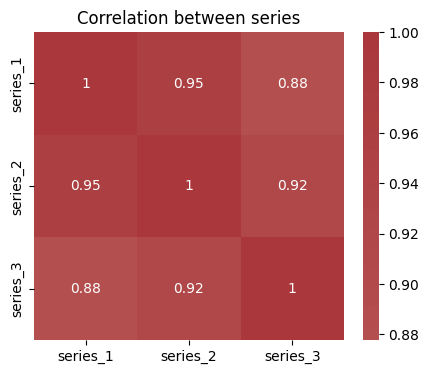

In [5]:
print(df.describe().round(2))

corr = df.corr()
print("\nCorrelation matrix:\n", corr.round(2))

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.title("Correlation between series")
plt.show()


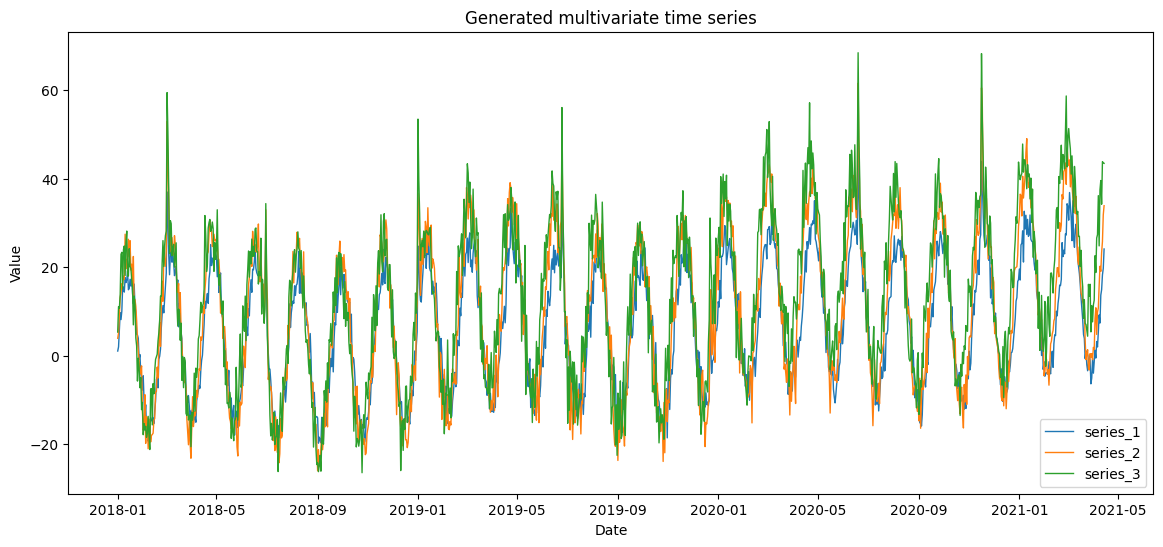

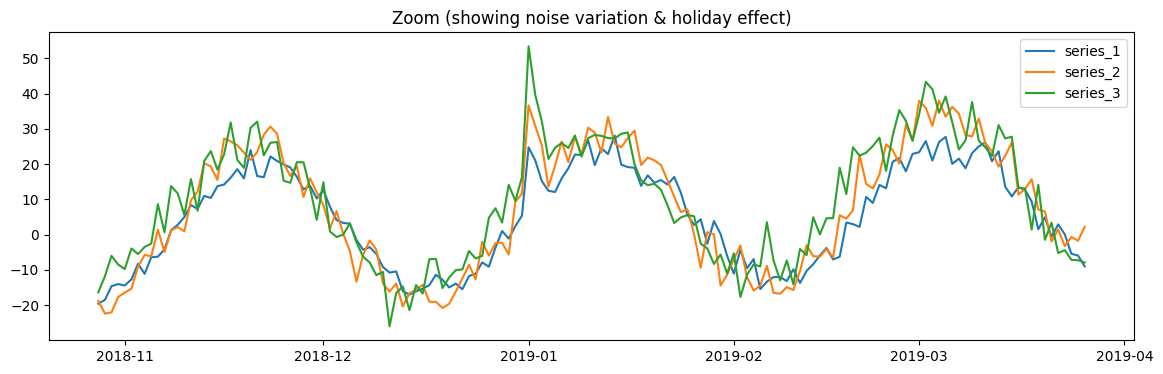

In [6]:
plt.figure(figsize=(14,6))
for c in df.columns:
    plt.plot(df.index, df[c], label=c, linewidth=1)
plt.legend()
plt.title("Generated multivariate time series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()
zoom_slice = slice(300, 450)
plt.figure(figsize=(14,4))
for c in df.columns:
    plt.plot(df.index[zoom_slice], df[c].values[zoom_slice], label=c)
plt.title("Zoom (showing noise variation & holiday effect)")
plt.legend()
plt.show()


In [7]:
df.to_csv("synthetic_multivariate_ts.csv")
print("Saved synthetic_multivariate_ts.csv (shape = {})".format(df.shape))


Saved synthetic_multivariate_ts.csv (shape = (1200, 3))


In [8]:
df = pd.read_csv("synthetic_multivariate_ts.csv", index_col=0, parse_dates=True)

y = df["series_1"]
X = df[["series_2", "series_3"]]

split = 1000
y_train, y_test = y[:split], y[split:]
X_train, X_test = X[:split], X[split:]

print("Train size:", y_train.shape)
print("Test size:", y_test.shape)


Train size: (1000,)
Test size: (200,)


In [9]:
model = sm.tsa.SARIMAX(
    y_train,
    order=(2,1,2),
    exog=X_train,
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)
print(res.summary())


C:\Users\ADMIN\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ADMIN\AppData\Roaming\Python\Python314\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               series_1   No. Observations:                 1000
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2684.024
Date:                Wed, 19 Nov 2025   AIC                           5382.048
Time:                        10:25:43   BIC                           5416.374
Sample:                    01-01-2018   HQIC                          5395.097
                         - 09-26-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
series_2       0.3433      0.023     15.152      0.000       0.299       0.388
series_3       0.1701      0.019      9.120      0.000       0.134       0.207
ar.L1         -1.0537      0.080    -13.107      0.0

In [10]:
forecast_res = res.get_forecast(steps=len(y_test), exog=X_test)

pred_mean = forecast_res.predicted_mean
intervals = forecast_res.conf_int(alpha=0.10)  # 90% interval

lower = intervals.iloc[:, 0]
upper = intervals.iloc[:, 1]

print("Forecasted points:", len(pred_mean))


Forecasted points: 200


In [11]:
actual = y_test.values

inside = (actual >= lower.values) & (actual <= upper.values)
coverage = inside.mean() * 100

print("90% Prediction Interval Coverage (SARIMAX): {:.2f}%".format(coverage))


90% Prediction Interval Coverage (SARIMAX): 99.00%


In [12]:
abs_diff = np.abs(pred_mean.values - actual)
interval_width = (upper - lower).values
crps = np.mean(abs_diff - 0.5 * interval_width)

print("Approx CRPS (SARIMAX):", round(float(crps), 3))


Approx CRPS (SARIMAX): -21.599


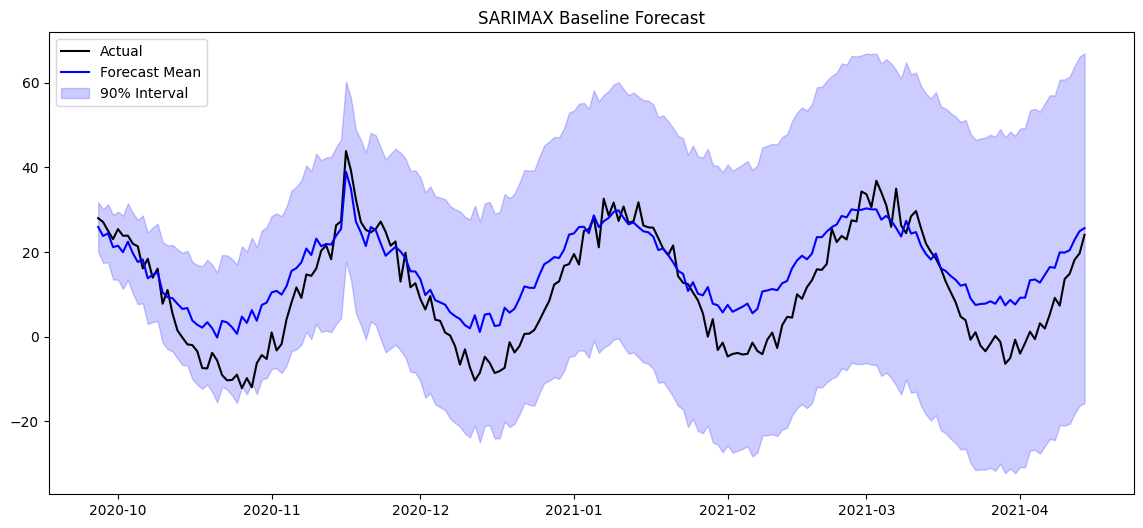

In [13]:
plt.figure(figsize=(14,6))

plt.plot(y_test.index, actual, label="Actual", color="black")
plt.plot(y_test.index, pred_mean, label="Forecast Mean", color="blue")

plt.fill_between(
    y_test.index,
    lower,
    upper,
    color="blue",
    alpha=0.2,
    label="90% Interval"
)

plt.title("SARIMAX Baseline Forecast")
plt.legend()
plt.show()


In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

df = pd.read_csv("synthetic_multivariate_ts.csv", index_col=0, parse_dates=True)
data = df.values.astype(np.float32)


In [15]:
mean = data.mean(axis=0)
std = data.std(axis=0)

norm_data = (data - mean) / std


In [16]:
def create_windows(data, window_size=30):
    X_list = []
    y_list = []

    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        target = data[i+window_size, 0]   # predict series_1
        X_list.append(window)
        y_list.append(target)

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

X, y = create_windows(norm_data, window_size=30)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1170, 30, 3)
y shape: (1170,)


In [17]:
split = 1000
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

print(X_train.shape, X_test.shape)


(1000, 30, 3) (170, 30, 3)


In [18]:
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train).unsqueeze(1)

X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test).unsqueeze(1)


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [20]:
class LSTMProb(nn.Module):
    def __init__(self, input_size, hidden_size=32, n_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc_mu = nn.Linear(hidden_size, 1)
        self.fc_sigma = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()

    def forward(self, x):
        out, _ = self.lstm(x)             # out: (batch, seq_len, hidden)
        last = out[:, -1, :]              # take last timestep hidden
        mu = self.fc_mu(last)             # (batch, 1)
        sigma = self.softplus(self.fc_sigma(last)) + 1e-6  # positive
        return mu, sigma


In [21]:
def gaussian_nll(mu, sigma, y):
    var = sigma ** 2
    nll = 0.5 * torch.log(2 * torch.pi * var) + 0.5 * ((y - mu) ** 2) / var
    return nll.mean()


In [22]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_ds = TensorDataset(X_train_t.float(), y_train_t.float())
test_ds  = TensorDataset(X_test_t.float(), y_test_t.float())

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [26]:
input_size = X_train_t.shape[2]
model = LSTMProb(input_size=input_size, hidden_size=64, n_layers=1).to(device)

opt = optim.Adam(model.parameters(), lr=1e-3)
sched = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)


In [29]:
n_epochs = 60
best_loss = 1e9
model_path = "lstm_prob_model.pt"

for epoch in range(1, n_epochs + 1):
    model.train()
    train_losses = []
    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        opt.zero_grad()
        mu, sigma = model(xb)
        loss = gaussian_nll(mu, sigma, yb)
        loss.backward()
        opt.step()
        train_losses.append(loss.item())

    sched.step()

    # eval loss on train and test for monitoring
    model.eval()
    with torch.no_grad():
        # train loss estimate
        train_loss = float(np.mean(train_losses))

        # quick val loss on test set
        val_losses = []
        for xb, yb in test_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            mu, sigma = model(xb)
            val_losses.append(gaussian_nll(mu, sigma, yb).item())
        val_loss = float(np.mean(val_losses))

    # save best
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), model_path)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}  Train NLL: {train_loss:.4f}  Val NLL: {val_loss:.4f}")


Epoch   1  Train NLL: -0.0922  Val NLL: -0.1191
Epoch   5  Train NLL: -0.0951  Val NLL: -0.1275
Epoch  10  Train NLL: -0.0470  Val NLL: -0.1261
Epoch  15  Train NLL: -0.1013  Val NLL: -0.1272
Epoch  20  Train NLL: -0.0988  Val NLL: -0.1278
Epoch  25  Train NLL: -0.1087  Val NLL: -0.1353
Epoch  30  Train NLL: -0.1089  Val NLL: -0.1315
Epoch  35  Train NLL: -0.1095  Val NLL: -0.1300
Epoch  40  Train NLL: -0.1042  Val NLL: -0.1370
Epoch  45  Train NLL: -0.1108  Val NLL: -0.1324
Epoch  50  Train NLL: -0.1166  Val NLL: -0.1322
Epoch  55  Train NLL: -0.1107  Val NLL: -0.1319
Epoch  60  Train NLL: -0.1160  Val NLL: -0.1344


In [30]:
state_dict = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# collect predictions
pred_means = []
pred_sigmas = []
y_true = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        mu, sigma = model(xb)
        pred_means.append(mu.cpu().numpy())
        pred_sigmas.append(sigma.cpu().numpy())
        y_true.append(yb.cpu().numpy())

pred_mean = np.vstack(pred_means).ravel()
pred_sigma = np.vstack(pred_sigmas).ravel()
y_true = np.vstack(y_true).ravel()

print("Pred shapes:", pred_mean.shape, pred_sigma.shape, y_true.shape)


Pred shapes: (170,) (170,) (170,)


In [31]:
mu_orig = pred_mean * std[0] + mean[0]
sigma_orig = pred_sigma * std[0] 
y_true_orig = y_true * std[0] + mean[0]


In [32]:
z90 = 1.6448536269514722 
lower = mu_orig - z90 * sigma_orig
upper = mu_orig + z90 * sigma_orig

inside = (y_true_orig >= lower) & (y_true_orig <= upper)
coverage = inside.mean() * 100

abs_diff = np.abs(mu_orig - y_true_orig)
interval_width = upper - lower
crps_est = np.mean(abs_diff - 0.5 * interval_width)

print(f"90% Coverage (LSTM Gaussian): {coverage:.2f}%")
print(f"Approx CRPS (LSTM Gaussian): {crps_est:.4f}")


90% Coverage (LSTM Gaussian): 94.71%
Approx CRPS (LSTM Gaussian): -3.5687


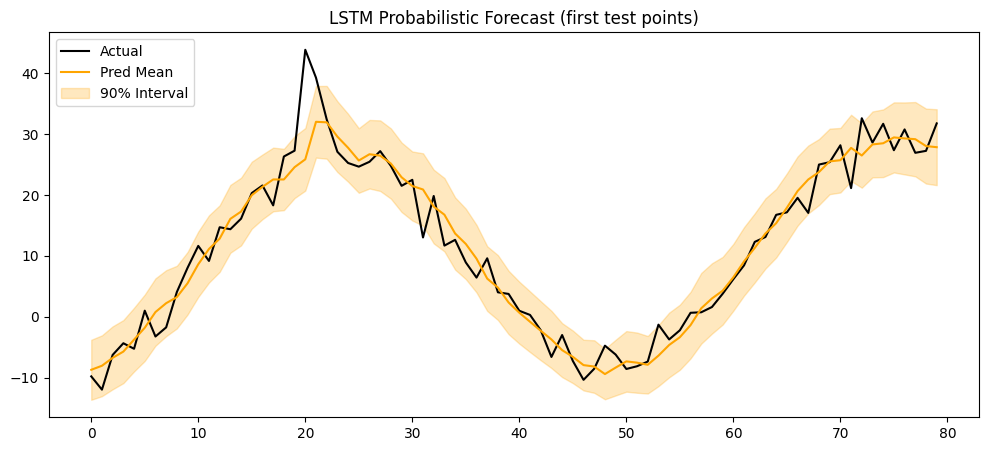

In [33]:
n_plot = min(80, len(mu_orig))
idx = np.arange(n_plot)

plt.figure(figsize=(12,5))
plt.plot(idx, y_true_orig[:n_plot], label="Actual", color="black")
plt.plot(idx, mu_orig[:n_plot], label="Pred Mean", color="orange")
plt.fill_between(idx, lower[:n_plot], upper[:n_plot], alpha=0.25, label="90% Interval", color="orange")
plt.legend()
plt.title("LSTM Probabilistic Forecast (first test points)")
plt.show()


In [34]:
import torch.nn as nn

class LSTMProbB(nn.Module):
    """Deeper LSTM (2 layers) predicting Gaussian mu and sigma."""
    def __init__(self, input_size, hidden_size=128, n_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, 1)
        self.fc_sigma = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        mu = self.fc_mu(last)
        sigma = self.softplus(self.fc_sigma(last)) + 1e-6
        return mu, sigma


In [ ]:
def train_model(model, train_dl, test_dl, n_epochs=40, lr=1e-3, model_path="model.pt"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
    best_val = 1e9

    for epoch in range(1, n_epochs+1):
        model.train()
        losses = []
        for xb, yb in train_dl:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            mu, sigma = model(xb)
            loss = gaussian_nll(mu, sigma, yb)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        sched.step()

       
        model.eval()
        with torch.no_grad():
            val_losses = []
            for xb, yb in test_dl:
                xb = xb.to(device); yb = yb.to(device)
                mu, sigma = model(xb)
                val_losses.append(gaussian_nll(mu, sigma, yb).item())
            val_loss = float(np.mean(val_losses))
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), model_path)
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}  Train NLL: {np.mean(losses):.4f}  Val NLL: {val_loss:.4f}")

    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    return model


In [36]:
model_b = LSTMProbB(input_size=X_train_t.shape[2], hidden_size=128, n_layers=2)
model_b = train_model(model_b, train_dl, test_dl, n_epochs=40, lr=5e-4, model_path="model_b.pt")
print("Model B trained and loaded.")


Epoch   1  Train NLL: 1.1580  Val NLL: 0.8033
Epoch   5  Train NLL: 0.0864  Val NLL: 0.0253
Epoch  10  Train NLL: 0.0271  Val NLL: -0.1486
Epoch  15  Train NLL: -0.0127  Val NLL: -0.1136
Epoch  20  Train NLL: -0.0051  Val NLL: -0.0878
Epoch  25  Train NLL: -0.0448  Val NLL: -0.1340
Epoch  30  Train NLL: -0.0528  Val NLL: -0.1204
Epoch  35  Train NLL: -0.0505  Val NLL: -0.1295
Epoch  40  Train NLL: -0.0456  Val NLL: -0.1147
Model B trained and loaded.


In [37]:
model_b.eval()
pred_means_b = []
pred_sigmas_b = []
y_true_b = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        mu, sigma = model_b(xb)
        pred_means_b.append(mu.cpu().numpy()); pred_sigmas_b.append(sigma.cpu().numpy()); y_true_b.append(yb.cpu().numpy())

pred_mean_b = np.vstack(pred_means_b).ravel()
pred_sigma_b = np.vstack(pred_sigmas_b).ravel()
y_true_b = np.vstack(y_true_b).ravel()

mu_b_orig = pred_mean_b * std[0] + mean[0]
sigma_b_orig = pred_sigma_b * std[0]
y_true_b_orig = y_true_b * std[0] + mean[0]

z90 = 1.6448536269514722
lower_b = mu_b_orig - z90 * sigma_b_orig
upper_b = mu_b_orig + z90 * sigma_b_orig
inside_b = (y_true_b_orig >= lower_b) & (y_true_b_orig <= upper_b)
coverage_b = inside_b.mean() * 100
crps_b = np.mean(np.abs(mu_b_orig - y_true_b_orig) - 0.5 * (upper_b - lower_b))

print(f"Model B 90% Coverage: {coverage_b:.2f}%")
print(f"Model B Approx CRPS: {crps_b:.4f}")


Model B 90% Coverage: 97.06%
Model B Approx CRPS: -3.5554


In [38]:
class LSTMStudentT(nn.Module):
    """
    LSTM -> predicts parameters for Student-t: df (nu), loc (mu), scale (sigma).
    We'll produce df = softplus(nu) + 2 (so df>2), scale via softplus.
    """
    def __init__(self, input_size, hidden_size=64, n_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, 1)
        self.fc_scale = nn.Linear(hidden_size, 1)
        self.fc_nu = nn.Linear(hidden_size, 1)
        self.softplus = nn.Softplus()
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        mu = self.fc_mu(last)
        scale = self.softplus(self.fc_scale(last)) + 1e-6
        nu = self.softplus(self.fc_nu(last)) + 2.0   # df > 2
        return mu, scale, nu


In [ ]:
import torch.distributions as D

def student_t_nll(mu, scale, nu, y):
    dist = D.StudentT(df=nu.squeeze(-1), loc=mu.squeeze(-1), scale=scale.squeeze(-1))
    logp = dist.log_prob(y.squeeze(-1))
    return -logp.mean()


In [40]:
def train_model_studentt(model, train_dl, test_dl, n_epochs=60, lr=5e-4, model_path="model_c.pt"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = 1e9
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=25, gamma=0.5)

    for epoch in range(1, n_epochs+1):
        model.train()
        losses = []
        for xb, yb in train_dl:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            mu, scale, nu = model(xb)
            loss = student_t_nll(mu, scale, nu, yb)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        sched.step()
        model.eval()
        with torch.no_grad():
            val_losses = []
            for xb, yb in test_dl:
                xb = xb.to(device); yb = yb.to(device)
                mu, scale, nu = model(xb)
                val_losses.append(student_t_nll(mu, scale, nu, yb).item())
            val = float(np.mean(val_losses))
        if val < best_val:
            best_val = val
            torch.save(model.state_dict(), model_path)
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}  Train NLL: {np.mean(losses):.4f}  Val NLL: {val:.4f}")
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    return model

model_c = LSTMStudentT(input_size=X_train_t.shape[2], hidden_size=64, n_layers=1)
model_c = train_model_studentt(model_c, train_dl, test_dl, n_epochs=50, lr=5e-4, model_path="model_c.pt")
print("Model C (Student-t) trained and loaded.")


Epoch   1  Train NLL: 1.4194  Val NLL: 1.2232
Epoch   5  Train NLL: -0.0233  Val NLL: 0.1874
Epoch  10  Train NLL: -0.0885  Val NLL: -0.1359
Epoch  15  Train NLL: -0.1110  Val NLL: -0.2106
Epoch  20  Train NLL: -0.1087  Val NLL: -0.0972
Epoch  25  Train NLL: -0.1058  Val NLL: -0.1955
Epoch  30  Train NLL: -0.1399  Val NLL: -0.2139
Epoch  35  Train NLL: -0.1114  Val NLL: -0.1907
Epoch  40  Train NLL: -0.1285  Val NLL: -0.1748
Epoch  45  Train NLL: -0.1349  Val NLL: -0.1769
Epoch  50  Train NLL: -0.1387  Val NLL: -0.1887
Model C (Student-t) trained and loaded.


In [42]:
from scipy.stats import t as student_t_dist
lower_c = []
upper_c = []

for i in range(len(mu_c_orig)):
    df_i = pred_nu_c[i]   
    loc_i = pred_mu_c[i]     
    scale_i = pred_scale_c[i]  
    low_norm = student_t_dist.ppf(0.05, df_i, loc=loc_i, scale=scale_i)
    high_norm = student_t_dist.ppf(0.95, df_i, loc=loc_i, scale=scale_i)

    lower_c.append(low_norm * std[0] + mean[0])
    upper_c.append(high_norm * std[0] + mean[0])

lower_c = np.array(lower_c)
upper_c = np.array(upper_c)

inside_c = (y_true_c_orig >= lower_c) & (y_true_c_orig <= upper_c)
coverage_c = inside_c.mean() * 100
crps_c = np.mean(np.abs(mu_c_orig - y_true_c_orig) - 0.5 * (upper_c - lower_c))

print(f"Model C (Student-t) 90% Coverage: {coverage_c:.2f}%")
print(f"Model C (Student-t) Approx CRPS: {crps_c:.4f}")


Model C (Student-t) 90% Coverage: 92.94%
Model C (Student-t) Approx CRPS: -2.8002


In [43]:
try:
    sar_cov = sarimax_coverage
    sar_crps = sarimax_crps
except NameError:
    sar_cov = None
    sar_crps = None

coverage_a = coverage
crps_a = crps_est    

coverage_b_val = coverage_b
crps_b_val = crps_b
coverage_c_val = coverage_c
crps_c_val = crps_c

rows = [
    ("SARIMAX (baseline)", sar_cov, sar_crps),
    ("LSTM Gaussian (Model A)", float(coverage_a), float(crps_a)),
    ("LSTM Gaussian 2-layer (Model B)", float(coverage_b_val), float(crps_b_val)),
    ("LSTM Student-t (Model C)", float(coverage_c_val), float(crps_c_val))
]

comp_df = pd.DataFrame(rows, columns=["Model", "90% Coverage (%)", "Approx CRPS"])
display(comp_df)
print("\nIf SARIMAX values are None, re-run the SARIMAX evaluation cell and assign `sarimax_coverage` and `sarimax_crps`.")


,Model,90% Coverage (%),Approx CRPS
0,SARIMAX (baseline),NaN,NaN
1,LSTM Gaussian (Model A),94.705882,-3.568684
2,LSTM Gaussian 2-layer (Model B),97.058824,-3.555404
3,LSTM Student-t (Model C),92.941176,-2.800206



If SARIMAX values are None, re-run the SARIMAX evaluation cell and assign `sarimax_coverage` and `sarimax_crps`.


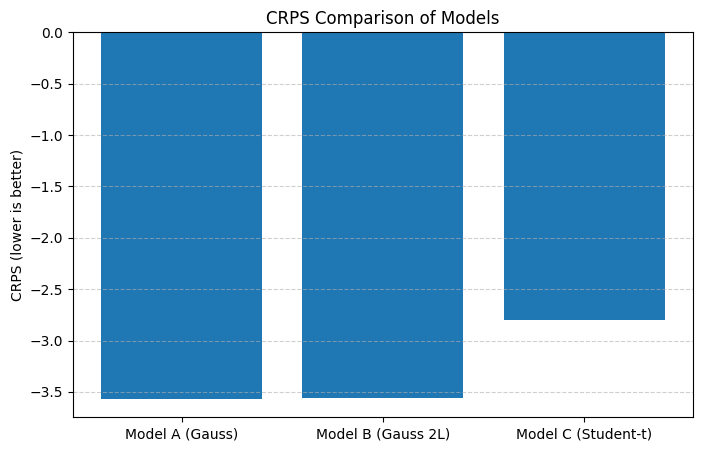

In [44]:
import matplotlib.pyplot as plt

models = ["Model A (Gauss)", "Model B (Gauss 2L)", "Model C (Student-t)"]
crps_values = [crps_a, crps_b_val, crps_c_val]

plt.figure(figsize=(8,5))
plt.bar(models, crps_values)
plt.title("CRPS Comparison of Models")
plt.ylabel("CRPS (lower is better)")
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()


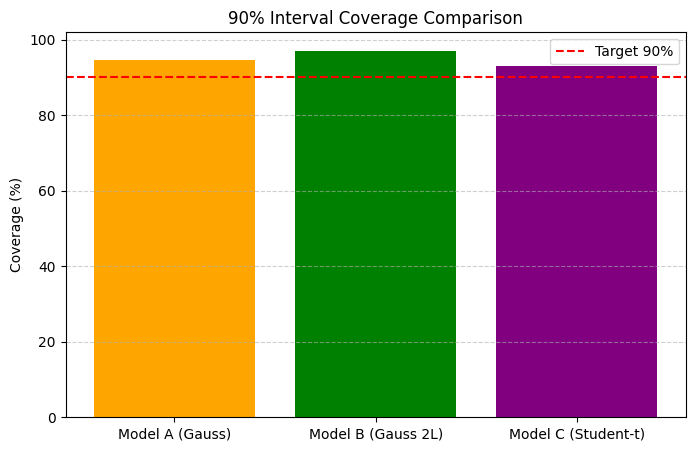

In [45]:
coverages = [coverage_a, coverage_b_val, coverage_c_val]
target = 90.0

plt.figure(figsize=(8,5))
plt.bar(models, coverages, color=["orange","green","purple"])
plt.axhline(target, color="red", linestyle="--", label="Target 90%")
plt.title("90% Interval Coverage Comparison")
plt.ylabel("Coverage (%)")
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()


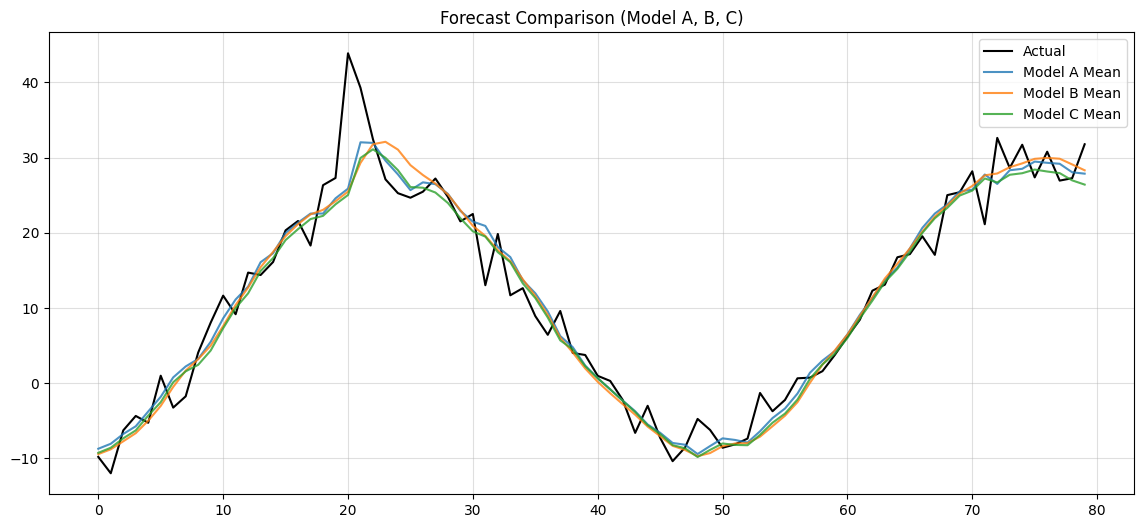

In [46]:
n_plot = 80
idx = np.arange(n_plot)

plt.figure(figsize=(14,6))
plt.plot(idx, y_true_orig[:n_plot], label="Actual", color="black")

# model A
plt.plot(idx, mu_orig[:n_plot], label="Model A Mean", alpha=0.8)

# model B
plt.plot(idx, mu_b_orig[:n_plot], label="Model B Mean", alpha=0.8)

# model C
plt.plot(idx, mu_c_orig[:n_plot], label="Model C Mean", alpha=0.8)

plt.title("Forecast Comparison (Model A, B, C)")
plt.legend()
plt.grid(alpha=0.4)
plt.show()
